<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b>  I tried to predict (classify) review stars with a fine-tuned Gemma 7B model using prompts. 
</span></i>

<i><span style="color:#e74c3c;"><b>NOTE: </b>  There was an issue with the Gemma model that returned the given prompt identically (almost 5% of all test predictions). I tried to solve this problem by choosing a random star. </span></i>
 

<b>Example Prompt: <i> Give this review a rating of 0 to 5, just one rating, no explanation. + REVIEW </i></b>


* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words etc.),
* I created <b>Gemma prompts</b>,
* I fine-tuned a Gemma 7B model with <b>LoRA</b>,
* I have modified this notebook [1],
* An end-2-end test prediction pipeline function,
* Test evaluation metrics <b>(f1 score, classification report etc.)</b>,


## Test Predictions
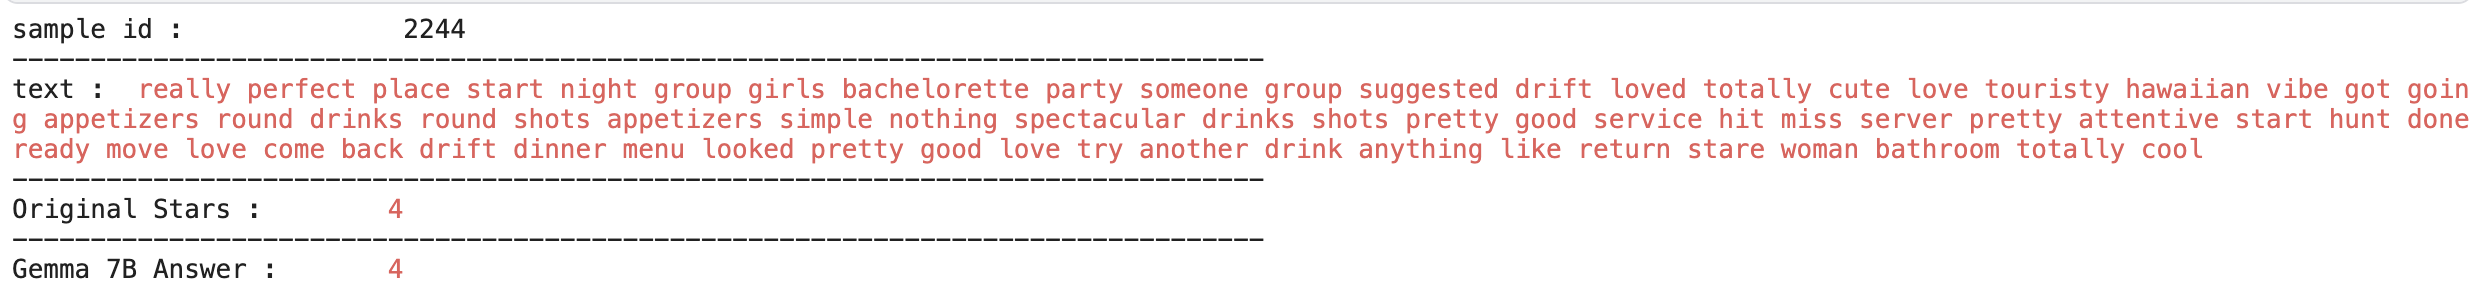
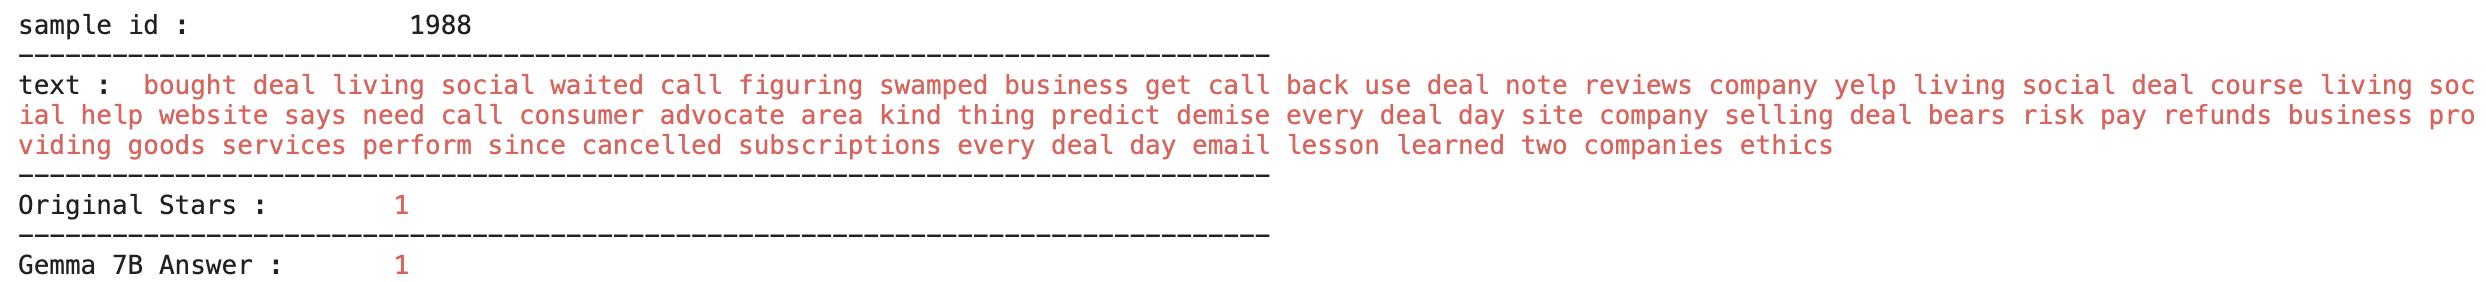


## My Another Projects
* [News Zero-Shot Topic Modelling w/BERTopic](https://www.kaggle.com/code/banddaniel/news-zero-shot-topic-modelling-w-bertopic)
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)


## References
1. https://ai.google.dev/gemma/docs/lora_tuning

In [1]:
from IPython.display import clear_output
!pip install --upgrade pip
!pip install -q tensorflow-cpu
!pip install -q -U keras-nlp tensorflow-hub
!pip install -q -U keras>=3
!pip install -U tensorflow-text
!pip install nltk colorama
clear_output()

In [93]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
from colorama import Fore, Back, Style
import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

import keras
import keras_nlp
import jax
import tensorflow as tf

SEED = 2

# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
# reading, dropping and shuffling
data = pd.read_csv('/kaggle/input/yelp-dataset/yelp.csv')
data.drop_duplicates(subset = ['review_id'], inplace = True)
data.drop(['business_id', 'date','review_id', 'user_id', 'cool','useful', 'funny', 'type'] ,axis = 1, inplace = True)
data = data.sample(frac = 1, random_state = SEED).reset_index(drop = True)
data.head()

,stars,text
0,4,Great prices and fresh food ...
1,4,Delicious kosher food in Scottsdale? Vegetari...
2,1,D-scust-ing.
3,4,"All around great. Great food, great atmospher..."
4,3,"Well it was off to Brio last night for ""date"" ..."


In [4]:
# calculating max token numbers and dropping several samples
data['max_token']= data['text'].apply(lambda X: len(X.split()))
drop_idx = data[(data['max_token'] == 0) | (data['max_token'] == 1) | (data['max_token'] == 2)].index
data.drop(index = drop_idx, inplace = True)
data.reset_index(drop = True)
data.shape

(9974, 3)

# <span style="color:#e74c3c;"> Preprocessing </span>

In [6]:
%%time
# preprocessing functions
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_text'] = data['text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


CPU times: user 2.21 s, sys: 11.3 ms, total: 2.22 s
Wall time: 2.33 s


In [94]:
full_data.head()

,stars,text,max_token,preprocessed_text
0,4,Great prices and fresh food ...,6,great prices fresh food
1,4,Delicious kosher food in Scottsdale? Vegetari...,122,delicious kosher food scottsdale vegetarian aw...
3,4,"All around great. Great food, great atmospher...",17,around great great food great atmosphere great...
4,3,"Well it was off to Brio last night for ""date"" ...",760,well brio last night date night last time brio...
5,3,Brunch Review:\n\nDYNaMITE BLOODYMARYS. Someth...,135,brunch review dynamite bloodymarys something s...


# <span style="color:#e74c3c;"> Dataset </span> Splitting

In [7]:
train_data, test_data = train_test_split(full_data, test_size = 0.4, random_state = SEED, stratify = full_data['stars'])

train_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print('train samples :\t', train_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 5984
test samples :	 3990


# <span style="color:#e74c3c;"> Creating </span> Prompts

In [8]:
def create_instruct_dataset(df: pd.DataFrame, for_train : bool) -> np.array :
    dataset = []
    for index, row in df.iterrows():
        review, stars = row['preprocessed_text'], row['stars']
        if for_train:
            template = (f"<start_of_turn>user\n Give this review a rating of 0 to 5, just one rating, no explanation.:\n{review}<end_of_turn>\n<start_of_turn>model\n{stars}'<end_of_turn>")
        else:
            template = (f"<start_of_turn>user\n Give this review a rating of 0 to 5, just one rating, no explanation.:\n{review}<end_of_turn>\n<start_of_turn>model\n")
        dataset.append(template)
        
    return dataset

In [9]:
%%time
train_dataset = create_instruct_dataset(train_data, True)
test_dataset = create_instruct_dataset(test_data, False)

CPU times: user 508 ms, sys: 0 ns, total: 508 ms
Wall time: 507 ms


In [95]:
# a train prompt example
pprint.pprint(train_dataset[40])

('<start_of_turn>user\n'
 ' Give this review a rating of 0 to 5, just one rating, no explanation.:\n'
 'pedicure nice give lady must wanted close shop early day told wanted pedi '
 'acrylic manicure first walked asked another customer come back next day '
 'getting pedi needless say get acrylic set towards end could tell arsing lil '
 'pricey mean really taking nail polish would give place star good job '
 'pedicure returning<end_of_turn>\n'
 '<start_of_turn>model\n'
 "2'<end_of_turn>")


# <span style="color:#e74c3c;"> Gemma 7B</span> Model

In [13]:
devices = jax.devices("tpu")
device_mesh = keras.distribution.DeviceMesh((1, 8), ["batch", "model"], devices=keras.distribution.list_devices())

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

In [11]:
model_parallel = keras.distribution.ModelParallel(device_mesh, layout_map, batch_dim_name="batch")
keras.distribution.set_distribution(model_parallel)
gemma = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_7b_en")

Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_instruct_7b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [19]:
# enabled lora
gemma.backbone.enable_lora(rank=8)

gemma.preprocessor.sequence_length = 256

optimizer = keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.01, beta_1=0.9, beta_2=0.999)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizer, weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()])

my_callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss',patience = 2, min_delta = 0.001)]

gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3072)        │   8,538,270,720 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     786,432,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,538,270,720 (31.81 GB)

 Trainable params: 13,172,736 (50.25 MB)

 Non-trainable params: 8,525,097,984 (31.76 GB)

# <span style="color:#e74c3c;"> Gemma 7B</span> Fine-Tuning

In [20]:
# fine-tuning
gemma.fit(train_dataset, epochs = 4, batch_size = 1, callbacks = my_callbacks)

Epoch 1/4
5984/5984 ━━━━━━━━━━━━━━━━━━━━ 863s 138ms/step - loss: 2.2145 - sparse_categorical_accuracy: 0.3366
Epoch 2/4
5984/5984 ━━━━━━━━━━━━━━━━━━━━ 822s 137ms/step - loss: 1.7106 - sparse_categorical_accuracy: 0.3828
Epoch 3/4
5984/5984 ━━━━━━━━━━━━━━━━━━━━ 821s 137ms/step - loss: 1.6669 - sparse_categorical_accuracy: 0.3893
Epoch 4/4
5984/5984 ━━━━━━━━━━━━━━━━━━━━ 821s 137ms/step - loss: 1.6366 - sparse_categorical_accuracy: 0.3988


# <span style="color:#e74c3c;"> Test</span> Predictions

In [28]:
# a function for creating test pipeline
# random test id -> generate with gemma -> split prediction

def predict_test_sample(original_df : pd.DataFrame, generated_prompt_arr : np.array, SEED: int = None):
    
    idx = np.random.default_rng(seed=SEED).permutation(original_df.shape[0])[0]
    print("sample id : \t\t", idx)
    print("--"*40)
    print("text :\t" +Fore.RED + original_df.iloc[idx].preprocessed_text + Style.RESET_ALL)
    
    print("--"*40)
    print("Original Stars :\t" +Fore.RED + str(original_df.iloc[idx].stars) + Style.RESET_ALL)

    print("--"*40)

    # gemma generated
    gemma_answer = gemma.generate(generated_prompt_arr[idx])
    final_gemma_answer = re.sub("'<end_of_turn>", ' ', re.split("<start_of_turn>model\n", gemma_answer)[-1])
    print("Gemma 7B Answer :\t" +Fore.RED + final_gemma_answer + Style.RESET_ALL)

In [100]:
# a random test answer with gemma
predict_test_sample(test_data, test_dataset, 123)

sample id : 		 292
--------------------------------------------------------------------------------
text :	record store memorial union always made nervous nearly everything building specifically designed rip students think hoodlums could possibly exception fortunately assumption incorrect hoodlums diverse selection awesome sales incredibly knowledgeable staff went well beyond pop charts always helpful atmosphere nice particularly moved basement store suffered smoke damage fire last autumn store going open union website states reappear future another location fingers crossed
--------------------------------------------------------------------------------
Original Stars :	4
--------------------------------------------------------------------------------
Gemma 7B Answer :	4 


In [99]:
# a random test answer with gemma
predict_test_sample(test_data, test_dataset, 5)

sample id : 		 1924
--------------------------------------------------------------------------------
text :	always consistent quality food service standard menu everything la carte specific location half dozen times recommend city hall mastro  scottsdale morton fleming tossup would eat either would probably choose fleming morton
--------------------------------------------------------------------------------
Original Stars :	4
--------------------------------------------------------------------------------
Gemma 7B Answer :	4 


In [31]:
# a random test answer with gemma
predict_test_sample(test_data, test_dataset, 3124)

sample id : 		 3367
--------------------------------------------------------------------------------
text :	stop every monday night negate two hours spinning yoga indulging mexican comfort food wife swears carne asado tacos cheese enchiladas ring bell although phone order parking lot always adventure however one night young hispanic girl celebrating birthday restaurant limited outdoor sitting area insisted come glass milk slice cake negated encounters strange transients
--------------------------------------------------------------------------------
Original Stars :	5
--------------------------------------------------------------------------------
Gemma 7B Answer :	4 


# <span style="color:#e74c3c;"> Test Dataset</span> Evaluation

In [75]:
# a function for predict the full dataset

def prediction_func(original_df : pd.DataFrame, generated_prompt_arr : np.array):
    
    true_stars = test_data['stars'].values
    gemma_pred_stars = []
    
    for idx in range(original_df.shape[0]):
        gemma_answer = gemma.generate(generated_prompt_arr[idx])
        final_gemma_answer = re.sub("'<end_of_turn>", ' ', re.split("<start_of_turn>model\n", gemma_answer)[-1])
        try:
            final_gemma_answer_int = int(final_gemma_answer)
        except ValueError:
            final_gemma_answer_int = np.random.randint(0,5) 
    
        gemma_pred_stars.append(final_gemma_answer_int)

    
    return true_stars, gemma_pred_stars

In [76]:
%%time
true_stars, gemma_pred_stars = prediction_func(test_data, test_dataset)

CPU times: user 2min 49s, sys: 14.6 s, total: 3min 3s
Wall time: 11min 10s


# <span style="color:#e74c3c;"> Test</span> Results

In [96]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true: np.array, y_pred : np.array) -> None:
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,  xticks_rotation="vertical", values_format = '2g', cmap = 'bone', colorbar = False)

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean Squared Error :	0.73409
Weighted F1 Score :	0.600
Accuracy Score :	60.602 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.69      0.58      0.63       298
           2       0.55      0.43      0.48       370
           3       0.51      0.41      0.45       584
           4       0.60      0.55      0.57      1409
           5       0.65      0.81      0.72      1329
           6       0.00      0.00      0.00         0

    accuracy                           0.61      3990
   macro avg       0.37      0.35      0.36      3990
weighted avg       0.60      0.61      0.60      3990

----------------------------------------------------------------------

 Confusion Matrix: 



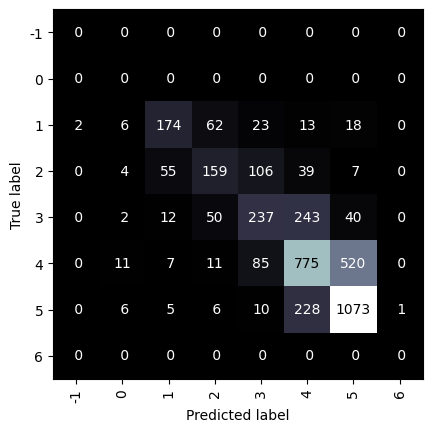

In [97]:
plot_prediction_results(true_stars, gemma_pred_stars)